# MNIST Classification test using ordinal encoding and sparse crossentropy loss

In [1]:
import numpy

In [2]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## Ordinal Encoding to Crossentropy
To use crossentropy we need to convert our output to a probability density. So we map the output x as follows:
$$x\mapsto \left[{e^{-x^2\over 2} \over \sum_{j=0}^{K-1} e^{-(x-j)^2\over 2}},{e^{-(x-i)^2\over2} \over \sum_{j=0}^{K-1} e^{-(x-j)^2\over 2}}{e^{-(x-K+1)^2\over 2} \over \sum_{j=0}^{K-1} e^{-(x-j)^2\over 2}}\right]$$ for $K$ categories. Basically it extracts each category with an enveloping gaussian and normalizes everything so the probabilities add up to 1.

#### Let's build and train our model
Here are some helper functions, the subordinal function performs the gaussian enveloping. The normalize converts the vector to have a total sum of one.

In [3]:
def softordinal(n):
    '''
    Generates a function that converts an ordinal coding to a set of "unnormalized probabilities
    @param n  number of categories
    '''
    r = tf.constant([range(0, n)], dtype=tf.float32)

    def func(x):
        qx = tf.matmul(x, tf.reshape(tf.ones(n), (1, n)))
        ex = (qx - r)
        sep = (tf.exp(-(ex * ex) / 2))
        sums = (tf.math.reduce_sum(sep, axis=1))
        return sep

    return func


def normalize(x, axis=None):
    '''
    Normalizes the vector so that sum of all components equals 1
    @param x    The input vector
    @param axis The axis to normalize over
    '''
    return (x / tf.reduce_sum(x, axis))

#### A noted about the model. It was difficult to bend tensorflow to my will here so I had to resort to two lambda layers otherwise it had a cow about the `Tensor` shapes

In [4]:
sce_model=tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(softordinal(10)),
  tf.keras.layers.Lambda(normalize)])

In [5]:
sce_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [6]:
sce_model.fit(x_train,
              y_train,
              epochs=20,
              validation_data=(x_test, y_test),
              verbose=0)

## We display some results
### The validation loss tells us how well the training went

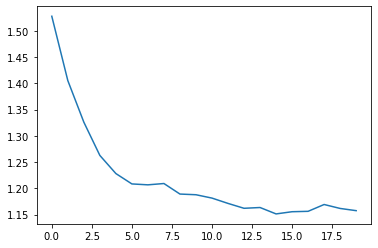

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown

plt.plot(sce_model.history.history['val_loss'])

### Print the final results in big bold text

In [8]:
text = "The accuracy is {:4.3f}% for the test set and {:4.3f}% for the training set".format(
    sce_model.history.history['val_accuracy'][-1]*100,
    sce_model.history.history['accuracy'][-1]*100)
display(Markdown(f"# {text}"))

# The accuracy is 63.750% for the test set and 54.750% for the training set

In [9]:
text

'The accuracy is 63.750% for the test set and 54.750% for the training set'

# Better than MSE but still not very good

Its interesting if you look at misclassifications, there is a lot of samples that are off by 1. For instance `2` gets labelled as `3` or `6` as `5`.